In [2]:
%load_ext autotime
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)

import platform
if platform.system() == "Windows":
  prefix = "Z:/"
else:
  prefix = "ressci201900060-RNC2-Coastal/"

df = pd.concat(pd.read_csv(f) for f in ["meta.csv"])
# Filter to just shapefiles that have the CPS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
#df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,photometric,Pixel_ER
0,Retrolens/Otago/Jacks_Surat_CannibalBay/Shorelines/Jacks_Surat_CannibalBay_28DEC2020.shp,Retrolens/Otago/Jacks_Surat_CannibalBay/Stack/Jacks_Surat_CannibalBay_28DEC2020_LDS.tif,100.0,LDS,5,True,True,True,GTiff,uint8,NaN,14336,13871,3,NaN,"| 0.30, 0.00, 1347175.90|\n| 0.00,-0.30, 4849236.90|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,4,"(0.30000000000000326, 0.29999999999998656)",NaN,0.300000
1,Retrolens/Otago/Tautuku/Shorelines/Tautuku_Beach_21FEB1967.shp,Retrolens/Otago/Tautuku/Stack/Tautuku_Beach_21FEB1967_mosaic.jp2,100.0,RL,7,True,True,True,JP2OpenJPEG,uint16,256.0,2236,2487,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.91, 0.00, 1324964.06|\n| 0.00,-1.91, 4836473.02|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(1.9082507602027026, 1.9082507602027892)",NaN,1.908251
2,Retrolens/Otago/LongBeach_PurakaunuiBay/Shorelines/LongBeach_PurakaunuiBay_20FEB1967.shp,Retrolens/Otago/LongBeach_PurakaunuiBay/Stack/LongBeach_PurakaunuiBay_20FEB1967_mosaic.jp2,100.0,RL,7,True,True,True,JP2OpenJPEG,uint16,256.0,2667,2069,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.88, 0.00, 1413910.36|\n| 0.00,-1.88, 4933293.55|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(1.881051678596278, 1.8810516785962599)",NaN,1.881052
3,Retrolens/Otago/TahakopaBay/Shorelines/TahakopaBay_17OCT1985.shp,Retrolens/Otago/TahakopaBay/Stack/TahakopaBay_17OCT1985_mosaic.jp2,100.0,RL,2,True,True,True,JP2OpenJPEG,uint16,256.0,12880,3787,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.72, 0.00, 1329224.31|\n| 0.00,-0.72, 4839064.87|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(0.721100800971447, 0.7211008009714511)",NaN,0.721101
4,Retrolens/Otago/NorthOamaru/Shorelines/NorthOamaru_17FEB1978.shp,Retrolens/Otago/NorthOamaru/Stack/NorthOamaru_17FEB1978_mosaic.jp2,100.0,RL,3,True,True,True,JP2OpenJPEG,uint16,256.0,6937,10273,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.39, 0.00, 1444469.57|\n| 0.00,-1.39, 5022505.93|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(1.3938155664445269, 1.39381556644449)",NaN,1.393816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,Retrolens/HawkesBay/Whirinaki/Shorelines/Whirinaki_26SEP1972.shp,Retrolens/HawkesBay/Whirinaki/Stack/Whirinaki_26SEP1972_mosaic.jp2,100.0,RL,5,True,True,True,JP2OpenJPEG,uint16,256.0,12955,22348,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.29, 0.00, 1934523.49|\n| 0.00,-0.29, 5638745.87|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(0.2936285038399954, 0.29362850384001593)",NaN,0.293629
2036,Retrolens/HawkesBay/Whirinaki/Shorelines/Whirinaki_07JUN1948.shp,Retrolens/HawkesBay/Whirinaki/Stack/Whirinaki_07JUN1948_mosaic.jp2,100.0,RL,4,True,True,True,JP2OpenJPEG,uint16,256.0,6452,11123,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.51, 0.00, 1934147.31|\n| 0.00,-0.51, 5637569.61|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(0.5069587087283669, 0.5069587087283983)",NaN,0.506959
2037,Retrolens/HawkesBay/Whirinaki/Shorelines/Whirinaki_10JUL1981.shp,Retrolens/HawkesBay/Whirinaki/Stack/Whirinaki_10JUL1981_mosaic.jp2,100.0,RL,3,True,True,True,JP2OpenJPEG,uint16,256.0,7051,8309,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 20

In [2]:
df = pd.concat((df, pd.read_csv(prefix+"Nick/LDS_matches.csv")))
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,photometric,Pixel_ER,matched_index_tiles,date,DSASDate,matched_date,matched_date_col
0,Retrolens/Otago/Jacks_Surat_CannibalBay/Shorelines/Jacks_Surat_CannibalBay_28DEC2020.shp,Retrolens/Otago/Jacks_Surat_CannibalBay/Stack/Jacks_Surat_CannibalBay_28DEC2020_LDS.tif,100.0,LDS,5.0,True,True,True,GTiff,uint8,NaN,14336.0,13871.0,3.0,NaN,"| 0.30, 0.00, 1347175.90|\n| 0.00,-0.30, 4849236.90|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,lzw,pixel,4.0,"(0.30000000000000326, 0.29999999999998656)",NaN,0.300000,NaN,NaN,NaN,NaN,NaN
1,Retrolens/Otago/Tautuku/Shorelines/Tautuku_Beach_21FEB1967.shp,Retrolens/Otago/Tautuku/Stack/Tautuku_Beach_21FEB1967_mosaic.jp2,100.0,RL,7.0,True,True,True,JP2OpenJPEG,uint16,256.0,2236.0,2487.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.91, 0.00, 1324964.06|\n| 0.00,-1.91, 4836473.02|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,pixel,0.0,"(1.9082507602027026, 1.9082507602027892)",NaN,1.908251,NaN,NaN,NaN,NaN,NaN
2,Retrolens/Otago/LongBeach_PurakaunuiBay/Shorelines/LongBeach_PurakaunuiBay_20FEB1967.shp,Retrolens/Otago/LongBeach_PurakaunuiBay/Stack/LongBeach_PurakaunuiBay_20FEB1967_mosaic.jp2,100.0,RL,7.0,True,True,True,JP2OpenJPEG,uint16,256.0,2667.0,2069.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.88, 0.00, 1413910.36|\n| 0.00,-1.88, 4933293.55|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,pixel,0.0,"(1.881051678596278, 1.8810516785962599)",NaN,1.881052,NaN,NaN,NaN,NaN,NaN
3,Retrolens/Otago/TahakopaBay/Shorelines/TahakopaBay_17OCT1985.shp,Retrolens/Otago/TahakopaBay/Stack/TahakopaBay_17OCT1985_mosaic.jp2,100.0,RL,2.0,True,True,True,JP2OpenJPEG,uint16,256.0,12880.0,3787.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.72, 0.00, 1329224.31|\n| 0.00,-0.72, 4839064.87|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,pixel,0.0,"(0.721100800971447, 0.7211008009714511)",NaN,0.721101,NaN,NaN,NaN,NaN,NaN
4,Retrolens/Otago/NorthOamaru/Shorelines/NorthOamaru_17FEB1978.shp,Retrolens/Otago/NorthOamaru/Stack/NorthOamaru_17FEB1978_mosaic.jp2,100.0,RL,3.0,True,True,True,JP2OpenJPEG,uint16,256.0,6937.0,10273.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.39, 0.00, 1444469.57|\n| 0.00,-1.39, 5022505.93|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,pixel,0.0,"(1.3938155664445269, 1.39381556644449)",NaN,1.393816,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,Retrolens/Gisborne/HuataiBeach/Shorelines/HuataiBeach_16FEB2018.shp,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300000,['SpatialData/Mosaics/Footprint shapefiles/lds-gisborne-03m-rural-aerial-photos-index-tiles-2017-2019-SHP (1)/gisborne-03m-rur...,'2018-02-16,'16/02/2018,'16/02/2018,FLOWN
378,Retrolens/Northland/BayleysBeach/Shorelines/BayleysBeach_06NOV2015.shp,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,['SpatialData/Mosaics/Footprint shapefiles/Northland Footrpints/northland-04m-rural-aerial-photos-index-tiles-2014-2016.shp'],'2015-11-06,'06/11/2015,"'06/11/2015, 07/11/2015",DATE_DMY
379,Retrolens/Taranaki/Oeo/Shorelines/Oeo_31OCT2016.shp,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300000,['SpatialData/Mosaics/Footprint shapefiles/Taranaki Footprints/taranaki-03m-rural-aerial-photos-index-tiles-2016-2018.shp'],'2016-10-31,'31/10/201

Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [3]:
#for f in df.filename:
#    print(f)
#    print(gpd.read_file(prefix+f))

In [4]:
#df = df[df.filename.str.startswith("Retrolens/Northland")]
#len(df)

In [5]:
# Warning: do not interrupt this cell while it is running. Doing so can delete or empty shapefiles that are in the process of being written.

def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"{prefix}{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        raise ValueError(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    if "RMSE" not in csv.columns:
        print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 80:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    if "RMSE" in csv.columns:
        filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    else:
        filtered_csv = csv[(csv.Date == matched_date)]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale):
    if not scale:
        return pd.NA
    elif scale < 20000:
        return 3.61
    elif scale < 30000:
        return 4.2
    else:
        return 5.03


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

def get_source(filename, shapefile):
    if "Source" not in shapefile.columns:
        #print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            return "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            return "MAX"
        else:
            return "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            #print(f"{filename} has no sources")
            if filename.startswith("Retrolens"):
                return "RL"
            elif filename.startswith("MaxarImagery/HighFreq"):
                return "MAX"
            else:
                return "Unknown"
        elif len(sources) == 1:
            return sources[0]
        elif len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
            return sources[0]
    return "Unknown"

def process_shapefile(tup):
    i,row=tup
    filename=row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    try:
        shapefile = gpd.read_file(prefix + filename)
        if "CPS" not in shapefile.columns:
            print(f"{filename} has no CPS")
            return
        original_shapefile = shapefile.copy()
    except:
        print(f"Can't read {filename}")
        return
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        return
    
    source = get_source(filename, shapefile)

    if source in ["MAX", "Max", "max", "PLE", "CRI", "NEO", "PNE", "GE1", "JIN", "JIL", "SAT", "VEX"]:
        photoscale = pd.NA
        Georef_ER = 2.02
    elif source == "LDS":
        photoscale = pd.NA
        Georef_ER = 0
    elif source in ["RL", "RLN", "RLS", "Rl", "RS"]:
        if "Photoscale" in shapefile.columns:
            photoscales = shapefile.Photoscale.unique()
            if len(photoscales) == 0:
                print(f"{filename} has no photoscale")
            elif len(photoscales) == 1:
                photoscale = photoscales[0]
                Georef_ER = get_Georef_ER(photoscale)
            elif len(photoscales) > 1:
                print(f"{filename} has ambiguous photoscales: {photoscales}")
                photoscale = shapefile.Photoscale
                Georef_ER = shapefile.Photoscale.map(get_Georef_ER)
            #print(f"Found photoscale in shapefile: {photoscale}")
        else:
            if "DSASdate" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSASdate
            elif "DSAS_NZDAT" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSAS_NZDAT
            elif "DSASDate" not in shapefile.columns:
                print(f"{filename} has no DSASDate")
                shapefile["DSASDate"] = year

            dates = shapefile.DSASDate.unique()
            if len(dates) > 1:
                print(f"{filename} has ambiguous DSASDates: {dates}")
            if len(dates) == 0 or not dates[0]:
                print(f"{filename} has no DSASDate")
                DSASDate = year
            else:
                DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")

            try:
                photoscale = get_scale(filename, DSASDate, year)
            except Exception as e:
                print(f"Got {e} when trying to get_scale for {filename}, {DSASDate}, {year}. Skipping")
                return
            Georef_ER = get_Georef_ER(photoscale)
    else:
        print(f"Source {source} not known, assuming MAX")
        photoscale = pd.NA
        Georef_ER = 2.02

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER

    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    for i, row in shapefile.iterrows():
        if row.CPS:
            row.CPS = float(row.CPS)
        if row.CPS not in CPS_error_lookup:
            #print(f"{row.CPS} not in CPS_error_lookup: {CPS_error_lookup}, skipping")
            continue
        Ed = CPS_error_lookup[row.CPS]
        # Override Taranaki Cliff Georef_ER
        if row.get("Proxy") and float(row.Proxy) in [3,4] and "Taranaki" in filename:
            #print(f"Overriding {row.Georef_ER} Georef_ER to 2.596504")
            shapefile.loc[i, "Georef_ER"] = 2.596504
            Eg = 2.596504
        else:
            Eg = row.Georef_ER
        if pd.isna(Eg):
            continue
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    #if type(photoscale) == pd.Series:
        #display(filename, shapefile)
    # To write results back to file:
    assert len(shapefile) > 0
    shapefile.to_file(prefix+filename)

for tup in tqdm(df.iterrows(), total=len(df)):
    process_shapefile(tup)
#thread_map(process_shapefile, df.iterrows(),total=len(df))

  0%|          | 0/2315 [00:00<?, ?it/s]

Retrolens/Otago/Warrington/Shorelines/Warrington_16FEB1985.shp has ambiguous photoscales: [25000     0]
Retrolens/Manawatu/KaiIwiBeach/Shorelines/KailwiBeach_31AUG1942_cliff.shp has ambiguous photoscales: [16000     0]
Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_13SEP1985.shp has ambiguous sources: ['RL' None]
Retrolens/WestCoast/Westport/Shorelines/Westport_15JAN1988.shp has ambiguous sources: ['Rl' 'RL']
ressci201900060-RNC2-Coastal/Retrolens/Wellington/PukeruaBay/PukeruaBay.csv has no RMSE column
Matching 22/08/1961 to 22/08/1961 0:00:00 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Wellington/PukeruaBay/PukeruaBay.csv
Retrolens/Northland/NorthHeadKaipara/Shorelines/NorthHeadKaipara_11MAY1938.shp has ambiguous photoscales: [    0 10800]
Retrolens/Northland/CapeReinga/Shorelines/CapeReinga_24DEC2021.shp has no DSASDate
Got No CSV found for ressci201900060-RNC2-Coastal/Retrolens/Northland/CapeReinga/*.csv when trying to get_scale for Retrolens/Northland/CapeRein

In [6]:
!./aggregate_shapefiles_to_geojson.py

./aggregate_shapefiles_to_geojson.py:36: TqdmWarning: Iterable length 2425 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  df = gpd.GeoDataFrame(pd.concat(process_map(read, df.filename))).to_crs(epsg=4326)
100%|███████████████████████████████████████| 2425/2425 [00:43<00:00, 55.21it/s]
/home/nyou045/.local/lib/python3.8/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NZGD2000 / New Zealand Transverse Mercator 2000 (the single non-null crs provided).
  warnings.warn(


In [3]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count                 18613
unique                 2871
top       1.599937498779249
freq                    742
Name: Total_UNCY, dtype: object

In [8]:
gpd.read_file("Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_24MAR1970.shp")

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Wellington,Kapiti North,1970-03-24,24/03/1970,MT,1000,None,RS,5,1,15840,2.09,0.289467,8.845337,"LINESTRING (1771832.627 5476002.926, 1771845.327 5476015.203, 1771856.546 5476026.633, 1771869.246 5476041.450, 1771879.406 54..."
1,0,Wellington,Kapiti North,1970-03-24,24/03/1970,MT,1000,None,RS,5,2,15840,2.09,0.289467,8.845337,"LINESTRING (1772016.174 5476211.625, 1772028.610 5476227.500, 1772042.368 5476243.639, 1772066.710 5476273.273, 1772091.581 54..."
2,0,Wellington,Kapiti North,1970-03-24,24/03/1970,MT,1000,None,RS,4,1,15840,2.09,0.289467,2.955806,"LINESTRING (1773265.539 5477890.939, 1773262.893 5477894.907, 1773265.275 5477903.639, 1773273.212 5477916.603, 1773284.854 54..."
3,0,Wellington,Kapiti North,1970-03-24,24/03/1970,MT,1000,None,RS,5,2,15840,2.09,0.289467,8.845337,"LINESTRING (1773797.194 5478593.515, 1773783.436 5478591.133, 1773773.382 5478594.044, 1773771.000 5478598.806, 1773768.884 54..."


In [9]:
df.Source.value_counts()

Source
RL     7827
LDS    4577
MAX    4425
RLN     780
Max     245
NEO     216
CRI     205
PLE     202
RLS      30
VEX      23
max      22
PNE      18
GE1      16
JIL       9
JIN       8
RS        6
WV3       1
SAT       1
Rl        1
Name: count, dtype: int64

In [10]:
df[df.Proxy.isin(["3","4"]) & df.filename.str.contains("Taranaki")].Region.value_counts(dropna=False)

Region
Taranaki          918
NorthTaranaki     278
SouthTaranaki     232
North Taranaki    117
South Taranaki     13
NothTaranaki        8
None                2
Name: count, dtype: int64

In [11]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
False    18613
True       612
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

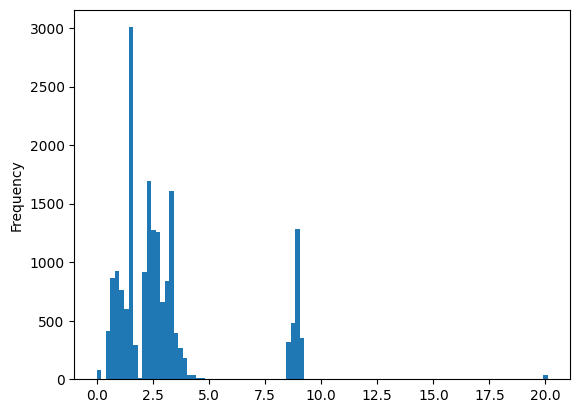

In [12]:
df.Total_UNCY = df.Total_UNCY.astype(float)
df.Total_UNCY.plot.hist(bins=100)

In [13]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Marlborough/CloudyBay/Shorelines/CloudyBay_02FEB2016.shp                     20.106837
Retrolens/Marlborough/WairauRiver/Shorelines/WairauRiver_07JAN2016.shp                 20.051572
Retrolens/Marlborough/CliffordBay/Shorelines/CliffordBay_07JAN2016.shp                 20.023509
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                       9.665489
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                       9.644290
Retrolens/Manawatu/HokioBeach/Shorelines/HokioBeach_30NOV1978.shp                       9.224321
Retrolens/Southland/MasonsBay/Shorelines/MasonsBay_10DEC1958.shp                        9.207819
Retrolens/Marlborough/CloudyBay/Shorelines/CloudyBay_04DEC2000.shp                      9.183342
Retrolens/HawkesBay/BayView/Shorelines/Bayview_17DEC1996.shp                            9.177801
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_31JAN1980.shp                       9.174151
Retrolens/Bay of Plen

In [14]:
df.groupby("Source").Total_UNCY.mean().sort_values(ascending=False).head(50)

Source
RS     5.819791
CRI    4.969550
RLN    4.036190
RL     3.947091
RLS    3.475330
NEO    3.026178
JIL    2.478732
SAT    2.478669
PLE    2.363835
MAX    2.348501
Rl     2.265828
LDS    2.221775
JIN    1.649160
Max    1.614848
max    1.568343
WV3    1.549129
PNE    1.535917
GE1    1.453410
VEX    1.391731
Name: Total_UNCY, dtype: float64

In [15]:
df.Photoscale.value_counts()

Photoscale
25000.0    1274
16000.0    1040
50000.0     605
44500.0     501
24000.0     442
           ... 
11600.0       2
18800.0       2
18850.0       1
19600.0       1
8300.0        1
Name: count, Length: 99, dtype: int64

In [16]:
df.Georef_ER.value_counts(dropna=False)

Georef_ER
1.17        5343
0           4205
2.09        2717
2.43        2572
2.9         2458
2.596504    1568
None         362
Name: count, dtype: int64